# Sheet 9

From Oliver Sange, Elias Huber and Sam Rouppe van der Voort

## 1 Pretraining LLMs
### a)

One method to pre-train the LLM would be that of Permutation Language Modeling. Here, the model gets a sentence where the tokens are in mixed order and the model has to predict the original order of the tokens. This is useful to train the model to capture the relationship between word in sentences and their corresponding meaning relative to their position.

Another method would be that of Replaced Token Detection, where a random token in a sentence gets replaced by another token. The model then has to classify all the tokens of the sentence, wheter or not they are the repalced token or original. This task is meaningful because it trains the model to detect which toekns/word are likely to appear depending on the surrounding words / sentence.


### b)

One meaningful pre-training task could be Masked Language Modeling (MLM) popularized by Bert, where the objective is to predict a randomly masked subset of the input tokens. This is meaningfull because it requires understanding of the contectual dependencies not just from the context before the unknown token or tokens, but also after. Computationally it requires more preprossesing of the training data because of the random masking. This is paralellizable since similarly to CLM because different subsets of training data with different contexts are independent and can be done in parallell. 

Another meaningful pre-training taks could be Sequence-to-Sequence Pretraining (Seq2Seq) This involves transforming an input sequence (e.g., original text) into a slightly modified target sequence, such as paraphrased text, reordered sentences, or translated versions.

This is meaningfull since it introduces a dynamic mapping between input and output spaces, making the model robust to variations and improving generalization.

Computationally it requires an encoder-Like Computation: The model essentially performs dual computation over input (encoder-like) and output (decoder-like) spaces.
Increased Training Cost: Requires processing input-output pairs, doubling the attention and computation load compared to single-sequence modeling.
Parallelization is challenging due to dependencies between input and output sequences during training. Decoding sequences often need to be generated step-by-step.
Large-scale data parallelism can still be applied by batching independent training samples, though the sequence decoding adds sequential computation overhead.

## 2 Under the hood of LLMs: Llama 2.7B

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# check if a cuda gpu is available, else use the cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# load access token
with open("access_token.txt", "r") as f:
    access_token = f.read().strip()

# load model llama-7b
model = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model, token=access_token, torch_dtype = torch.float16).to(device)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

In [2]:
# we chck 10 different ids of tokens in the dictionary of the model
for id in range(5100, 5110):
    # use the model to decode the id back to the token
    print(f"{id=}, {tokenizer.decode([id])}")
# total number of tokens
print("\ntokenizer length:", len(tokenizer))

# now do the reverse: encode the token "sun" to obtain the token id
sun_id = tokenizer.encode("sun", return_tensors="pt")[-1]
print(f"\n{sun_id=}")

# check if we decode again the same token is printed
print(tokenizer.decode(sun_id))

# obtain the embedding of the token "sun"
emb = model.get_input_embeddings()(sun_id.to(device))
print("embedding shape:", emb.shape)

id=5100, compet
id=5101, pair
id=5102, inglés
id=5103, Response
id=5104, Fig
id=5105, grad
id=5106, documentation
id=5107, cant
id=5108, appreci
id=5109, ån

tokenizer length: 32000

sun_id=tensor([   1, 6575])
<s> sun
embedding shape: torch.Size([2, 4096])


In [3]:
# input sequence 
sequence = "My favorite composer is"
# turn sequence to list of tokens
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)
# now decode tokens
print(tokenizer.decode(model_inputs["input_ids"].tolist()[0])) # view tokenized input
# compute likelihood of next tokens
with torch.no_grad():
    outputs = model(**model_inputs)
# number of possible output tokens
logits = outputs['logits'][0, -1, :]
print("\nlogits shape:", logits.shape)
# calc probabilites from scores by applying softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)
# chekc top 7 most likely output tokens
top_k = 7
top_prob, top_ind = torch.topk(probabilities, top_k)
# print them
print("\nOutputs:\n")

for i in range(top_k):
    print(f"{tokenizer.decode(top_ind[i].tolist())}: {top_prob[i]:.2f}")

<s> My favorite composer is

logits shape: torch.Size([32000])

Outputs:

Moz: 0.25
Ch: 0.11
Be: 0.09
Ludwig: 0.08
Fr: 0.03
Wolfgang: 0.02
Ig: 0.02


In [4]:
import regex as re

sequence = ""
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)

generated_answer = ""
# iteratively generate next token 
for _ in range(30):
    with torch.no_grad():
        #compute model outputs
        outputs = model(**model_inputs)
        # compute scores
        logits = outputs['logits'][0, -1, :]
        # compute probabilites
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        # compute next token
        next_token_id = torch.argmax(probabilities).unsqueeze(0)
        #append token
        model_inputs["input_ids"] = torch.cat([model_inputs["input_ids"], next_token_id.unsqueeze(0)], dim=-1)
    # turn id to token and append to generated answer
    next_word = tokenizer.decode(next_token_id.tolist())
    next_word = re.sub(r"[^a-zA-Z0-9.?!]", "", next_word)
    generated_answer += next_word
    generated_answer += " "
    
    print(generated_answer)

Unterscheidung 
Unterscheidung zwischen 
Unterscheidung zwischen  
Unterscheidung zwischen  K 
Unterscheidung zwischen  K raft 
Unterscheidung zwischen  K raft  
Unterscheidung zwischen  K raft  und 
Unterscheidung zwischen  K raft  und  
Unterscheidung zwischen  K raft  und  K 
Unterscheidung zwischen  K raft  und  K raft 
Unterscheidung zwischen  K raft  und  K raft werk 
Unterscheidung zwischen  K raft  und  K raft werk  
Unterscheidung zwischen  K raft  und  K raft werk   
Unterscheidung zwischen  K raft  und  K raft werk    
Unterscheidung zwischen  K raft  und  K raft werk     
Unterscheidung zwischen  K raft  und  K raft werk     K 
Unterscheidung zwischen  K raft  und  K raft werk     K raft 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  K 
Unterscheidung zwische

## 3 Flow-based modeling

### (b)

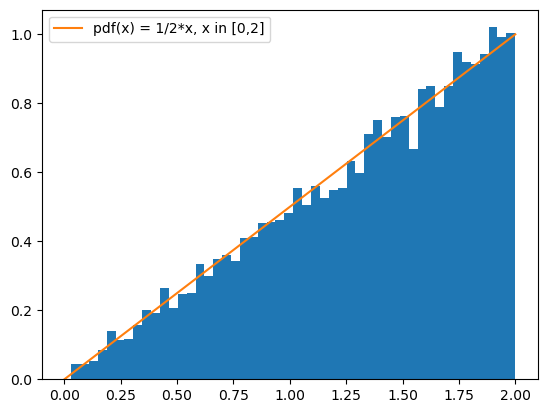

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# load the 1d samples:
samples = np.load("data/samples_1d.npy")

x_lin = np.linspace(0, 2, 1000)
plt.hist(samples, bins=50, density=True)
plt.plot(x_lin, 1/2 * x_lin, label="pdf(x) = 1/2*x, x in [0,2]")
plt.legend()
plt.show()

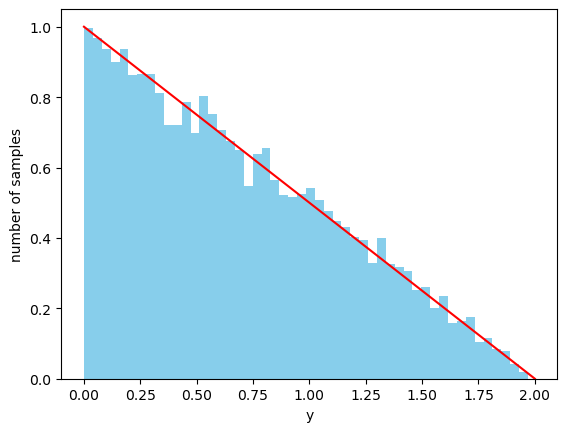

In [9]:
# TODO: transform the samples to samples from pdf(y) = -1/2*y + 1, y in [0,2]
def p_X(x):
    return 1/2 * x

def p_Y(y):
    return -1/2*y + 1

# Transform samples
y_samples = 2 - np.sqrt(4 - samples**2)

# Plot
y = np.linspace(0, 2, 1000)
#fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot pdf
plt.plot(x_lin, p_Y(y), color='red')
plt.xlabel('y')
plt.ylabel(r'$p_{Y}(y)$')

# Plot histogram
plt.hist(y_samples, bins=50, density=True, color='skyblue',)
plt.xlabel('y')
plt.ylabel(r'number of samples')

plt.show()